<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Shallow/Full_Linear_Evaluation_Imagenet_Subset_Shallow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Thu Aug 20 12:40:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Restoring model weights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/Souradip\ Sayak/SimCLR_PseudoLabels/Models/resnet_simclr_modified_ae_shallow.h5 .

In [5]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset gathering and preparation

In [6]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 12.82 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [8]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [9]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  5%|▍         | 12/250 [00:00<00:02, 115.83it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 192.64it/s]


(250, 224, 224, 3) (250,)


In [10]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [11]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [12]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights('resnet_simclr_modified_ae_shallow.h5')
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [13]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [14]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [15]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 128) (250, 128)


In [16]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/100
20/20 [==============================] - 0s 12ms/step - loss: 2.3418 - accuracy: 0.3024 - val_loss: 1.7211 - val_accuracy: 0.3760
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.7141 - accuracy: 0.3432 - val_loss: 1.4924 - val_accuracy: 0.4240
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 1.5393 - accuracy: 0.4144 - val_loss: 1.4038 - val_accuracy: 0.4600
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1.4677 - accuracy: 0.4288 - val_loss: 1.3572 - val_accuracy: 0.4640
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 1.4193 - accuracy: 0.4376 - val_loss: 1.3271 - val_accuracy: 0.4680
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3920 - accuracy: 0.4520 - val_loss: 1.3071 - val_accuracy: 0.4640
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3592 - accuracy: 0.4600 - val_loss: 1.2823 - val_accuracy: 0.4840
Epoch 8/100


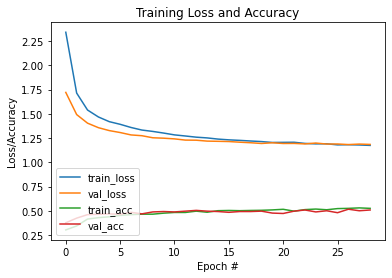

In [17]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [18]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 256) (250, 256)


Epoch 1/35
20/20 [==============================] - 0s 9ms/step - loss: 2.1449 - accuracy: 0.3120 - val_loss: 1.6921 - val_accuracy: 0.3440
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 1.6240 - accuracy: 0.3816 - val_loss: 1.3908 - val_accuracy: 0.4440
Epoch 3/35
20/20 [==============================] - 0s 4ms/step - loss: 1.4043 - accuracy: 0.4480 - val_loss: 1.2785 - val_accuracy: 0.4840
Epoch 4/35
20/20 [==============================] - 0s 4ms/step - loss: 1.3066 - accuracy: 0.4600 - val_loss: 1.2195 - val_accuracy: 0.5040
Epoch 5/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2622 - accuracy: 0.4888 - val_loss: 1.1966 - val_accuracy: 0.5160
Epoch 6/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2451 - accuracy: 0.5056 - val_loss: 1.2077 - val_accuracy: 0.4880
Epoch 7/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2286 - accuracy: 0.4952 - val_loss: 1.1849 - val_accuracy: 0.5080
Epoch 8/35
20/20 [==

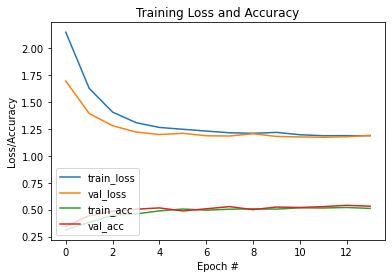

In [19]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [20]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(1250, 2048) (250, 2048)


Epoch 1/35
20/20 [==============================] - 0s 10ms/step - loss: 1.7874 - accuracy: 0.2944 - val_loss: 1.4056 - val_accuracy: 0.4160
Epoch 2/35
20/20 [==============================] - 0s 4ms/step - loss: 1.3689 - accuracy: 0.4512 - val_loss: 1.2458 - val_accuracy: 0.5040
Epoch 3/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2519 - accuracy: 0.4784 - val_loss: 1.2470 - val_accuracy: 0.4960
Epoch 4/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2273 - accuracy: 0.5040 - val_loss: 1.2081 - val_accuracy: 0.4560
Epoch 5/35
20/20 [==============================] - 0s 4ms/step - loss: 1.1899 - accuracy: 0.5064 - val_loss: 1.1929 - val_accuracy: 0.4840
Epoch 6/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2332 - accuracy: 0.5136 - val_loss: 1.2224 - val_accuracy: 0.4680
Epoch 7/35
20/20 [==============================] - 0s 4ms/step - loss: 1.2279 - accuracy: 0.4760 - val_loss: 1.1723 - val_accuracy: 0.5280
Epoch 8/35
20/20 [=

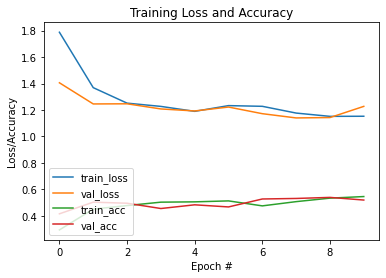

In [21]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)